# 实战案例：基于对应表示的跨模态检索
:label:`sec_cross-modal-retrieval-vsepp`

## 跨模态检索技术简介

![计算图文匹配分数的两类方法](../img/cr-corr-vs-joint.png)
:label:`fig_cr-corr-vs-joint`

跨模态检索的关键就是建立不同模态数据之间的关联，更直接地，模型需要能够输出多个模态数据的匹配分数。如 :numref:`fig_cr-corr-vs-joint`所示，现有的方法可以被分为两类：一是学习图文多模态对应表示，然后直接利用图像和文本的对应表示的距离计算匹配分数，我们称这类模型为对应表示方法；二是学习图文多模态共享表示，然后在共享表示层上增加一个或多个网络层直接输出图像和文本的匹配分数，我们称这类模型为共享表示方法。

一般而言，和对应表示方法相比，共享表示方法因为充分融合了图文信息，可以获得更好的性能。一个直观的理解是给定两个模态的数据，对应表示方法限定了两个模态的关联必须是在没有交互的前提下建立，而共享表示方法则没有该限制。因此，共享表示方法拥有更大的自由度来拟合数据的分布。

然而，共享表示方法的检索非常耗时。例如，在执行以文检图任务中，需要将文本查询和候选集中的每一张图片都成对的输入到模型中，才能得到文本查询与候选集中所有图片的匹配分数。
而对应表示方法只需要提前离线计算好候选集中所有图片的表示，然后在检索时，只需要实时计算文本查询的表示，再利用最近邻检索算法搜索图像最近邻即可。
因此，对应表示方法在实际的跨模态检索中使用更为广泛。

接下来，我们将具体介绍使用对应表示方法的模型VSE++ :cite:`Fa.Fl.Ki.ea.2018` 的实战案例，其官方代码见[链接](https://github.com/fartashf/vsepp)。为了使读者更清晰的理解模型的训练过程，我们重新实现了该模型。

## 模型训练流程
:label:`sec_cross-modal-retrieval-vsepp-trainingprocess`

![模型训练的一般流程](../img/cr-traning_process.png)
:label:`fig_cr-training-process`

从现代的深度学习框架基础下，模型训练的一般流程如 :numref:`fig_cr-training-process` 所示，包括读取数据、前馈计算、计算损失、更新参数、选择模型五个步骤。每个步骤需要实现相应的模块。

- 在读取数据阶段，我们首先需要下载数据集，然后对整理数据集的格式，以方便接下来构造数据集类，最后在数据集类的基础上构建能够按批次产生训练、验证和测试数据的对象。

- 在前馈计算阶段，我们需要实现具体的模型，使得模型能够根据输入产生相应的输出。

- 在计算损失阶段，我们需要将模型输出和预期输出进行对比，实现损失函数。

- 在更新参数阶段，我们需要给出具体的参数更新方法，即优化方法；由于现代深度学习框架能够自动计算参数梯度，并实现了绝大多数优化方法，我们通常只需要从中进行选择即可。

- 在选择模型阶段，我们需要实现具体的评估指标，选出在验证集上表现最优的模型参数。

下面，我们将介绍VSE++模型的这些阶段的具体实现，并在最后将这些阶段串联起来，最终实现模型的训练。

## 读取数据
:label:`sec_vsepp-read-dataset`

### 下载数据集
:label:`sec_vsepp-download-dataset`

我们使用的数据集为flickr8k([下载地址](https://www.kaggle.com/adityajn105/flickr8k))，下载解压后，我们将其图片放在指定目录(本节的代码中将该目录设置为../data/flickr8k)下的images文件夹里。该数据集包括8000张图片，每张图片对应5个句子描述。数据集划分采用Karpathy提供的方法([下载地址](http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip))，下载解压后，将其中的dataset_flickr8k.json文件拷贝到指定目录下。该划分方法将数据集分成3个子集：6,000张图片和其对应句子描述组成训练集，1,000张图片和描述为验证集，剩余的1,000张图片和描述为测试集。

### 整理数据集

数据集下载完成后，我们需要对其进行处理，以适合之后构造的PyTorch数据集类读取。对于文本描述，我们首先构建词典，然后根据词典将文本描述转化为向量。对于图像，我们这里仅记录文件路径。如果机器的内存和硬盘空间就比较大，这里也可以将图片读取并处理成三维数组，这样在模型训练和测试的阶段，就不需要再直接读取图片。下面是整理数据集的函数的代码。


In [1]:
import random, os, tqdm, time, json, re
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from datetime import datetime

import sys
random.seed(618)
np.random.seed(907)

sys.path.append("../../")
new_base_path = os.path.join(
    "/mnt/d/forCoding_data/",
    "/".join(
        os.getcwd().split("/")[-1*(len(sys.path[-1].split("/")) - 1):]
    ),
)
# sys.path.append("..\\..\\")
# new_base_path = os.path.join(
#     "D:\\forCoding_data\\",
#     "\\".join(
#         os.getcwd().split("\\")[-1*(len(sys.path[-1].split("\\")) - 1):]
#     ),
# )

print("storage dir:", new_base_path)
print("code dir:", os.getcwd())

storage dir: /mnt/d/forCoding_data/ML_runCodeFromBook/多模态深度学习技术基础
code dir: /Users/minkexiu/Documents/GitHub/ML_runCodeFromBook/多模态深度学习技术基础


In [2]:
## 创建文件夹。
if not os.path.exists(new_base_path):
    os.makedirs(
        new_base_path
    )
if not os.path.exists(os.path.join(new_base_path, "preprocessedData")):
    os.makedirs(
        os.path.join(new_base_path, "preprocessedData")
    )
if not os.path.exists(os.path.join(new_base_path, "originalData")):
    os.makedirs(
        os.path.join(new_base_path, "originalData")
    )
if not os.path.exists(os.path.join(new_base_path, "trained_models")):
    os.makedirs(
        os.path.join(new_base_path, "trained_models")
    )

def create_originalData_path(filename_or_path):
    return os.path.join(new_base_path, "originalData", filename_or_path)
def create_preprocessedData_path(filename_or_path):
    return os.path.join(new_base_path, "preprocessedData", filename_or_path)
def create_trained_models_path(filename_or_path):
    return os.path.join(new_base_path, "trained_models", filename_or_path)

def millisec2datetime(timestamp):
    time_local = time.localtime(timestamp/1000)
    return time.strftime("%Y-%m-%d %H:%M:%S", time_local)
    
def run_finish():
    # 假设你的字体文件是 'myfont.ttf' 并且位于当前目录下  
    font = FontProperties(fname="/Users/minkexiu/Documents/GitHub/ML_Tryout/SimHei.ttf", size=24)  
    # 创建一个空白的图形  
    fig, ax = plt.subplots()  
    ax.imshow(
        plt.imread("/Users/minkexiu/Downloads/wallhaven-dgxpyg.jpg")
    )
    # 在图形中添加文字  
    ax.text(
        ax.get_xlim()[1] * 0.5, 
        ax.get_ylim()[0] * 0.5, 
        f"程序于这个点跑完：\n{millisec2datetime(time.time()*1000)}", fontproperties=font, ha="center", va="center", color="red"
    )  
    # 设置图形的布局  
    # ax.set_xlim(0, 1)  
    # ax.set_ylim(0, 1)  
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.patch.set_color("blue")
    # 显示图形  
    plt.show()
        
tqdm.tqdm.pandas() ## 引入这个，就可以在apply的时候用progress_apply了。

import IPython
def kill_current_kernel():
    '''杀死当前的kernel释放内存空间。'''
    IPython.Application.instance().kernel.do_shutdown(True) 
    
def simply_show_data(df1):
    print(df1.shape)
    display(df1.head())
    
def wait_flag(saved_flag_path, time_interval_sec=10):
    print("waiting for", saved_flag_path)
    time_count = 0
    while True:
        if os.path.exists(saved_flag_path):
            break
        time.sleep(time_interval_sec)
        time_count+=time_interval_sec
        print(time_count, end=" ")
    print("finish!!")

def parallelly_run_multiple_similar_python_code(codes, nb_workers = 4):
    '''
    codes是多条相似的python代码。
    这个函数的作用就是将其平行地跑，每一条python代码就对应一个线程。或许可以后续优化，比如固定线程数为一个特定值。
    nb_workers 如果赋值为
    '''
    assert (isinstance(nb_workers, int)), "`nb_workers' should be int."
    df_sqls = pd.DataFrame(
        {
            "func": codes

        }
    )
    display(df_sqls)
    from pandarallel import pandarallel
    pandarallel.initialize(nb_workers = df_sqls.shape[0] if nb_workers<0 else nb_workers, progress_bar = True)
    def run_sql_prlly(row):
        try: 
            cmd = f'{row["func"]}'
            print(cmd, "\n")
            eval(cmd)
            return "0-success"
        except Exception as e:
            return e
    df_sqls["run_rsts"] = df_sqls.parallel_apply(lambda row: run_sql_prlly(row), axis = 1)
    display(df_sqls)
    
def create_originalData_path(filename_or_path):
    return os.path.join(new_base_path, "originalData", filename_or_path)
def create_preprocessedData_path(filename_or_path):
    return os.path.join(new_base_path, "preprocessedData", filename_or_path)
def create_trained_models_path(filename_or_path):
    return os.path.join(new_base_path, "trained_models", filename_or_path)
    
class TimerContext:  
    def __enter__(self):  
        self.start_time = str(datetime.now())
        print("start time:", self.start_time)
        return self  
    def __exit__(self, exc_type, exc_val, exc_tb):  
        print("start time:", self.start_time)
        print("end time", str(datetime.now()))

def three_num_get_gua(a, b, c):
    '''梅花易数三数起卦，以取本、互、变。'''
    bagua = ["111", "110", "101", "100", "011", "010", "001", "000"]
    guatu = {
        "111": ("☰", "天", "乾金"), 
        "110": ("☱", "泽", "兑金"),
        "101": ("☲", "火", "离火"),
        "100": ("☳" , "雷", "震木"),
        "011": ("☴", "风", "巽木"),
        "010": ("☵", "水", "坎水"),
        "001": ("☶", "山", "艮土"),
        "000": ("☷", "地", "坤土"),
    }
    shanggua_idx = 7 if (a % 8 == 0) else (a % 8 - 1)
    xiagua_idx = 7 if (b % 8 == 0) else (b % 8 - 1)
    bianyao_idx = 5 if (c % 6 == 0) else (c % 6 - 1)
    bengua = bagua[xiagua_idx] + bagua[shanggua_idx]
    hugua = bengua[1:-1][:3] + bengua[1:-1][1:]
    biangua = list(bengua)
    biangua[bianyao_idx] = str(1 - int(biangua[bianyao_idx]))
    biangua = "".join(biangua)
    df = pd.DataFrame([[
        guatu[bengua[3:]][0]+guatu[bengua[3:]][2], guatu[hugua[3:]][0]+guatu[hugua[3:]][2], guatu[biangua[3:]][0]+guatu[biangua[3:]][2], 
    ],[
        guatu[bengua[:3]][0]+guatu[bengua[:3]][2], guatu[hugua[:3]][0]+guatu[hugua[:3]][2], guatu[biangua[:3]][0]+guatu[biangua[:3]][2], 
    ]], index=["上卦", "下卦"], columns = [
        guatu[bengua[3:]][1] + guatu[bengua[:3]][1],
        guatu[hugua[3:]][1] + guatu[hugua[:3]][1],
        guatu[biangua[3:]][1] + guatu[biangua[:3]][1],
    ])
    display(df)
    return bengua, hugua, biangua
    
def easy_start_gua():
    """用公历的日、时、分来起卦。"""
    n1, n2, n3 = str(datetime.now())[8:10], str(datetime.now())[11:13], str(datetime.now())[14:16]
    print(n1, n2, n3)
    return three_num_get_gua(int(n1), int(n2), int(n3))
easy_start_gua()

import zhdate
def easy_start_gua_lunar():
    '''用农历的月、日、时辰来起卦。'''
    time_now = datetime.now()
    zh_date_str = str(zhdate.ZhDate.from_datetime(time_now))
    zh_date_str_1 = datetime.strftime(
        datetime(
            *[int(x) for x in re.findall("\d+", zh_date_str)]
        ),
        '%Y-%m-%d'
    )
    zh_hour = (time_now.hour + 1)//2%12+1
    zh_hour_dizhi = "子、丑、寅、卯、辰、巳、午、未、申、酉、戌、亥".split("、")[zh_hour-1]
    
    n1, n2, n3 = zh_date_str_1[5:7], zh_date_str_1[8:10], zh_hour
    print(n1, n2, n3, f"{zh_hour_dizhi}时")
    return three_num_get_gua(int(n1), int(n2), int(n3))
easy_start_gua_lunar()

<>:165: SyntaxWarning: invalid escape sequence '\d'
<>:165: SyntaxWarning: invalid escape sequence '\d'
/var/folders/s1/1jpfx0m52rj4k7cgqkh7g3q40000gn/T/ipykernel_16140/2849389036.py:165: SyntaxWarning: invalid escape sequence '\d'
  *[int(x) for x in re.findall("\d+", zh_date_str)]
/var/folders/s1/1jpfx0m52rj4k7cgqkh7g3q40000gn/T/ipykernel_16140/2849389036.py:165: SyntaxWarning: invalid escape sequence '\d'
  *[int(x) for x in re.findall("\d+", zh_date_str)]


OSError: [Errno 30] Read-only file system: '/mnt'

In [3]:
%matplotlib inline
import os
import json
import random 
from collections import defaultdict, Counter
from PIL import Image
from matplotlib import pyplot as plt

def create_dataset(dataset='flickr8k',
                   captions_per_image=5, 
                   min_word_count=5, 
                   max_len=30):
    """
    参数：
        dataset：数据集名称
        captions_per_image：每张图片对应的文本描述数
        min_word_count：仅考虑在数据集中（除测试集外）出现5次的词
        max_len：文本描述包含的最大单词数，如果文本描述超过该值，则截断
    输出：
        一个词典文件： vocab.json
        三个数据集文件： train_data.json、 val_data.json、 test_data.json
    """

    karpathy_json_path= create_originalData_path("%s/dataset_flickr8k.json" % dataset) # '../data/%s/dataset_flickr8k.json' % dataset
    image_folder= create_originalData_path("%s/Images" % dataset) # '../data/%s/images' % dataset
    output_folder= create_originalData_path("%s" % dataset) # '../data/%s' % dataset

    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)
    
    image_paths = defaultdict(list)
    image_captions = defaultdict(list)
    vocab = Counter()

    for img in data['images']:
        split = img['split']
        captions = []
        for c in img['sentences']:
            # 更新词频，测试集在训练过程中是未见数据集，不能统计
            if split != 'test':
                vocab.update(c['tokens'])
            # 不统计超过最大长度限制的词
            if len(c['tokens']) <= max_len:
                captions.append(c['tokens'])
        if len(captions) == 0:
            continue

        path = os.path.join(image_folder, img['filename'])
        
        image_paths[split].append(path)
        image_captions[split].append(captions)

    # 创建词典，增加占位标识符<pad>、未登录词标识符<unk>、句子首尾标识符<start>和<end>
    words = [w for w in vocab.keys() if vocab[w] > min_word_count]
    vocab = {k: v + 1 for v, k in enumerate(words)}
    vocab['<pad>'] = 0
    vocab['<unk>'] = len(vocab)
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)

    # 存储词典
    with open(os.path.join(output_folder, 'vocab.json'), 'w') as fw:
        json.dump(vocab, fw)

    # 整理数据集
    for split in image_paths:
        imgpaths = image_paths[split]
        imcaps = image_captions[split]
        
        enc_captions = []

        for i, path in enumerate(imgpaths):
            # 合法性检查，检查图像是否可以被解析
            img = Image.open(path) 
            # 如果该图片对应的描述数量不足，则补足
            if len(imcaps[i]) < captions_per_image:
                captions = imcaps[i] + \
                    [random.choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
            # 如果该图片对应的描述数量超了，则随机采样
            else:
                captions = random.sample(imcaps[i], k=captions_per_image)
            assert len(captions) == captions_per_image
            
            for j, c in enumerate(captions):
                # 对文本描述进行编码
                enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']] 
                enc_captions.append(enc_c)
        # 合法性检查
        assert len(imgpaths) * captions_per_image == len(enc_captions)
        
        # 存储数据
        data = {'IMAGES': imgpaths, 
                'CAPTIONS': enc_captions}
        with open(os.path.join(output_folder, split + '_data.json'), 'w') as fw:
            json.dump(data, fw)

create_dataset()

在调用该函数生成需要的格式的数据集文件之后，我们可以展示其中一条数据，简单验证下数据的格式是否和我们预想的一致。

<start> a dog standing in shallow water on a red leash <end>
<start> black dog in the water shaking the water off of him <end>
<start> a black dog is shaking water off his body <end>
<start> a dog splashes in the murky water <end>
<start> a dog on a leash shakes while in some water <end>


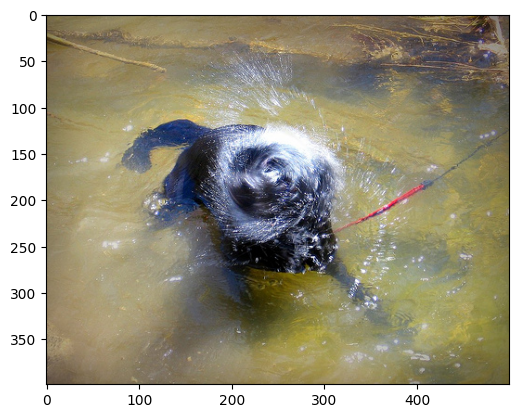

In [4]:
# 读取词典和验证集
with open(create_originalData_path("flickr8k/vocab.json"), 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word,idx in vocab.items()}
with open(create_originalData_path("flickr8k/val_data.json"), 'r') as f:
    data = json.load(f)

# 展示第12张图片，其对应的文本描述序号是60到64
content_img = Image.open(data['IMAGES'][12])
plt.imshow(content_img)
for i in range(5):
    print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][12*5+i]]))


### 定义数据集类

在准备好的数据集的基础上，我们需要进一步定义PyTorch Dataset类，以使用PyTorch DataLoader类按批次产生数据。PyTorch中仅预先定义了图像、文本和语音的单模态任务中常见的数据集类。因此，我们需要定义自己的数据集类。

在PyTorch中定义数据集类非常简单，仅需要继承torch.utils.data.Dataset类，并实现__getitem__和__len__两个函数即可。

In [5]:
from argparse import Namespace 
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

class ImageTextDataset(Dataset):
    """
    PyTorch数据类，用于PyTorch DataLoader来按批次产生数据
    """

    def __init__(self, dataset_path, vocab_path, split, captions_per_image=5, max_len=30, transform=None):
        """
        参数：
            dataset_path：json格式数据文件路径
            vocab_path：json格式词典文件路径
            split：train、val、test
            captions_per_image：每张图片对应的文本描述数
            max_len：文本描述包含的最大单词数
            transform: 图像预处理方法
        """
        self.split = split
        assert self.split in {'train', 'val', 'test'}
        self.cpi = captions_per_image
        self.max_len = max_len

        # 载入数据集
        with open(dataset_path, 'r') as f:
            self.data = json.load(f)
        # 载入词典
        with open(vocab_path, 'r') as f:
            self.vocab = json.load(f)

        # PyTorch图像预处理流程
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.data['CAPTIONS'])

    def __getitem__(self, i):
        # 第i个文本描述对应第(i // captions_per_image)张图片
        img = Image.open(self.data['IMAGES'][i // self.cpi]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        caplen = len(self.data['CAPTIONS'][i])
        caption = torch.LongTensor(self.data['CAPTIONS'][i]+ [self.vocab['<pad>']] * (self.max_len + 2 - caplen))

        return img, caption, caplen
        

    def __len__(self):
        return self.dataset_size

### 批量读取数据

利用刚才构造的数据集类，借助DataLoader类构建能够按批次产生训练、验证和测试数据的对象。

In [6]:
def mktrainval(data_dir, vocab_path, batch_size, workers=4):
    train_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_set = ImageTextDataset(os.path.join(data_dir, 'train_data.json'), 
                                 vocab_path, 'train',  transform=train_tx)
    valid_set = ImageTextDataset(os.path.join(data_dir, 'val_data.json'), 
                                 vocab_path, 'val', transform=val_tx)
    test_set = ImageTextDataset(os.path.join(data_dir, 'test_data.json'), 
                                 vocab_path, 'test', transform=val_tx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)

    return train_loader, valid_loader, test_loader    


## 定义模型

![VSE++的模型结构示意图](../img/mr-vsepp-modelarch.png)
:label:`fig_mr-vsepp-modelarch`

如 :numref:`fig_mr-vsepp-modelarch` 所示，VSE++模型是由图像表示提取器和文本表示提取构成，二者将图像和文本映射到对应表示空间。其中，图像表示提取器为在ImageNet数据集上预训练的VGG19或ResNet-152，VGG19和ResNet-152分别输出4096维和2048维的图像特征；文本表示提取器为GRU模型。

### 图像表示提取器

这里使用在ImageNet数据集上预训练过的两个分类模型ResNet-152和VGG19作为图像表示提取器，二者都需要更改其最后一个全连接层（分类层），以输出符合对应表示空间维度的图像表示。需要注意的是，这里对图像表示进行了长度归一化。

In [7]:
class ImageRepExtractor(nn.Module):
    def __init__(self, embed_size, pretrained_model='resnet152', finetuned=True):
        """
        参数：
            embed_size：对应表示维度
            pretrained_model：图像表示提取器，resnet152或vgg19
            finetuned：是否微调图像表示提取器的参数
        """
        super(ImageRepExtractor, self).__init__()
        if pretrained_model == 'resnet152':
            net = torchvision.models.resnet152(pretrained=True)
            for param in net.parameters():
                param.requires_grad = finetuned
            # 更改最后一层（fc层）
            net.fc = nn.Linear(net.fc.in_features, embed_size)
            nn.init.xavier_uniform_(net.fc.weight)
        elif pretrained_model == 'vgg19':
            net = torchvision.models.vgg19(pretrained=True)
            for param in net.parameters():
                param.requires_grad = finetuned
            # 更改最后一层（fc层）
            net.classifier[6] = nn.Linear(net.classifier[6].in_features, embed_size)
            nn.init.xavier_uniform_(net.classifier[6].weight)
        else:
            raise ValueError("Unknown image model " + pretrained_model)
        self.net = net

    def forward(self, x):
        out = self.net(x)
        out = nn.functional.normalize(out)
        return out

### 文本表示提取器

这里使用GRU模型作为文本表示提取器，它的输入层为词嵌入形式，文本表示为最后一个词对应的隐藏层输出。文本表示的维度也和对应表示空间的维度相同且也进行了长度归一化。

由于文本序列长度不一致，我们给长度较短的序列填充了大量的0（<pad>在词典中的序号），如果这些0都参与 RNN 的运算，势必会浪费大量的计算资源。由于RNN是按照时刻顺序计算隐藏层，即RNN在每一时刻的输入为小批量中相应时刻的维度数据，因此，我们可以将每一时刻的非0数据组合成一个批次当做RNN的输入。PyTorch中的pack_padded_sequence函数可以帮助我们轻松的做到这件事。具体来说，在将序列送给 RNN 进行处理之前，采用 pack_padded_sequence 函数对小批量的输入数据进行压缩，压缩掉无效的填充值。

![pack_padded_sequence函数的作用的示例图](../img/cr-pack_padded_sequence-example.png)
:label:`fig_cr-pack_padded_sequence-example`

这里，我们用一个例子来说明 pack_padded_sequence 函数的输入和输出。对于 :numref:`fig_cr-pack_padded_sequence-example` 所示的数量为4、最大长度为5的一个小批次样本，pack_padded_sequence 函数会按照时刻，统计出新的小批量数据，即输出的data包含全部非0数据，batch_sizes包含每一时刻对应的批大小。需要注意的是，使用pack_padded_sequence函数，必须预先对输入按照长度从大到小排序。

In [8]:
class TextRepExtractor(nn.Module):
    def __init__(self, vocab_size, word_dim, embed_size, num_layers):
        """
        参数：
            vocab_size：词典大小
            word_dim：词嵌入维度
            embed_size：对应表示维度，也是RNN隐藏层维度
            num_layers：RNN隐藏层数
        """
        super(TextRepExtractor, self).__init__()
        self.embed_size = embed_size
        self.embed = nn.Embedding(vocab_size, word_dim)
        self.rnn = nn.GRU(word_dim, embed_size, num_layers, batch_first=True)
        # RNN默认已初始化，这里只需要初始化词嵌入矩阵
        self.embed.weight.data.uniform_(-0.1, 0.1)
    
    def forward(self, x, lengths):
        x = self.embed(x)
        # 压缩掉填充值
        packed = pack_padded_sequence(x, lengths, batch_first=True) 
        # 执行GRU的前馈过程会返回两个变量，第二个变量hidden为最后一个词（由length决定）对应的所有隐藏层输出
        _, hidden = self.rnn(packed) 
        # 最后一个词的最后一个隐藏层输出为hidden[-1]
        out = nn.functional.normalize(hidden[-1])
        return out


### VSE++模型

有了图像表示提取器和文本表示提取器，我们就很容易构建VSE++模型了。仅需要利用图像表示提取器和文本表示提取器对成对的图像和文本数据输出表示即可。

这里需要注意的是要先按照文本的长短对数据进行排序，且为了评测模型时能够对齐图像和文本数据，我们需要恢复数据原始的输入顺序。

In [9]:
class VSEPP(nn.Module):
    def __init__(self, vocab_size, word_dim, embed_size, num_layers, image_model, finetuned=True):
        """
        参数：
            vocab_size: 词表大小
            word_dim: 词嵌入维度
            embed_size: 对应表示维度，也是RNN隐藏层维度
            num_layers: RNN隐藏层数
            image_model: 图像表示提取器，resnet152或vgg19
            finetuned: 是否微调图像表示提取器的参数
        """
        super(VSEPP, self).__init__()
        self.image_extractor = ImageRepExtractor(embed_size, image_model, finetuned)
        self.text_extractor = TextRepExtractor(vocab_size, word_dim, embed_size, num_layers)

    def forward(self, images, captions, cap_lens):
        # 按照caption的长短排序，并对照调整image的顺序
        sorted_cap_lens, sorted_cap_indices = torch.sort(cap_lens, 0, True)
        images = images[sorted_cap_indices]
        captions = captions[sorted_cap_indices]
        cap_lens = sorted_cap_lens

        image_code = self.image_extractor(images)
        text_code = self.text_extractor(captions, cap_lens)
        if not self.training:
            # 恢复数据原始的输入顺序
            _, recover_indices = torch.sort(sorted_cap_indices)
            image_code = image_code[recover_indices]
            text_code = text_code[recover_indices]
        return image_code, text_code

## 定义损失函数

VSE++模型采用了困难样本挖掘的triplet损失函数。一般而言，挖掘困难样本的方式分为离线挖掘和在线挖掘两种。其中离线挖掘是在训练开始或每一轮训练完成之后，挖掘困难样本；在线挖掘是在每一个批数据里，挖掘困难样本。这里的实现方式为在线挖掘。本部分代码的实现参照了VSE++模型的作者发布的[源码](https://github.com/fartashf/vsepp)。

In [10]:
class TripletNetLoss(nn.Module):
    def __init__(self, margin=0.2, hard_negative=False):
        super(TripletNetLoss, self).__init__()
        self.margin = margin
        self.hard_negative = hard_negative

    def forward(self, ie, te):
        """
        参数：
            ie：图像表示
            te：文本表示
        """
        scores  = ie.mm(te.t())
        diagonal = scores.diag().view(ie.size(0), 1)
        d1 = diagonal.expand_as(scores)
        d2 = diagonal.t().expand_as(scores)

        # 图像为锚
        cost_i = (self.margin + scores - d1).clamp(min=0)
        # 文本为锚
        cost_t = (self.margin + scores - d2).clamp(min=0)

        mask = torch.eye(scores.size(0), dtype=torch.bool)
        I = torch.autograd.Variable(mask)
        if torch.cuda.is_available():
            I = I.cuda()
        cost_i = cost_i.masked_fill_(I, 0)
        cost_t = cost_t.masked_fill_(I, 0)

        # 寻找困难样本
        if self.hard_negative:
            cost_i = cost_i.max(1)[0]
            cost_t = cost_t.max(0)[0]

        return cost_i.sum() + cost_t.sum()

## 选择优化方法

我们选用Adam优化算法来更新模型参数，学习速率采用分段衰减方法。

In [11]:
def get_optimizer(model, config):
    return torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=config.learning_rate)
    
def adjust_learning_rate(optimizer, epoch, config):
    """每隔lr_update个轮次，学习速率减小至当前二分之一"""
    lr = max(config.learning_rate * (0.5 ** (epoch // config.lr_update)), config.min_learning_rate)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## 评估指标

这里实现了跨模态检索中最常用的评估指标Recall@K。该指标是正确答案出现在前K个返回结果的样例占总样例的比例，比如在以图检文任务中，对于单一图片查询，在文本候选集中搜索它的K个最近邻的文本，如果返回的前K个文本中有至少一个文本和查询图片匹配，则该次查询的分数记为1，否则记为0。Recall@K是测试集中所有查询图片分数的平均。注意这里和推荐系统里Recall@K是完全不一样的，推荐系统里的Recall@K是K个推荐条目中的相关条目数量在所有相关条目数量的占比，衡量的是系统的查全率。

我们首先利用VSE++模型计算图像和文本编码，然后直接计算所有图像编码和所有文本编码之间的点积得到所有图像文本对之间的相似度得分（由于相邻的若干张图片是一张的，所以我们每个固定数量取图片即可），最后利用得分排序计算Recall@K。需要注意的是，对于图像查询，即在以图检文任务中，由于一张图片对应多个文本，我们需要找到和图像对应的排名最靠前的文本的位置。

In [12]:
def evaluate(data_loader, model, batch_size, captions_per_image):
    # 模型切换进入评估模式
    model.eval()
    image_codes = None
    text_codes = None
    device = next(model.parameters()).device
    for i, (imgs, caps, caplens) in enumerate(data_loader):
        with torch.no_grad():
            image_code, text_code = model(imgs.to(device), caps.to(device), caplens)
            if image_codes is None:
                image_codes = np.zeros((len(data_loader.dataset), image_code.size(1)))
                text_codes = np.zeros((len(data_loader.dataset), text_code.size(1)))
            # 将图文对应表示存到numpy数组中，之后在cpu上计算recall
            image_codes[i*batch_size:(i+1)*batch_size] = image_code.data.cpu().numpy()
            text_codes[i*batch_size:(i+1)*batch_size] = text_code.data.cpu().numpy()
    # 模型切换回训练模式
    model.train()
    return calc_recall(image_codes, text_codes, captions_per_image)

def calc_recall(image_codes, text_codes, captions_per_image):
    #之所以可以每隔固定数量取图片，是因为前面对图文数据对输入顺序进行了还原
    scores = np.dot(image_codes[::captions_per_image], text_codes.T) 
    # 以图检文：按行从大到小排序
    sorted_scores_indices = (-scores).argsort(axis=1)
    (n_image, n_text) = scores.shape
    ranks_i2t = np.zeros(n_image)
    for i in range(n_image):
        # 一张图片对应cpi条文本，找到排名最靠前的文本位置
        min_rank = 1e10
        for j in range(i*captions_per_image,(i+1)*captions_per_image):
            rank = list(sorted_scores_indices[i,:]).index(j)
            if min_rank > rank:
                min_rank = rank
        ranks_i2t[i] = min_rank
    # 以文检图：按列从大到小排序
    sorted_scores_indices = (-scores).argsort(axis=0)
    ranks_t2i = np.zeros(n_text)
    for i in range(n_text):
        rank = list(sorted_scores_indices[:,i]).index(i//captions_per_image)
        ranks_t2i[i] = rank
    # 最靠前的位置小于k，即为recall@k，这里计算了k取1、5、10时的图文互检的recall
    r1_i2t = 100.0 * len(np.where(ranks_i2t<1)[0]) / n_image
    r1_t2i = 100.0 * len(np.where(ranks_t2i<1)[0]) / n_text
    r5_i2t = 100.0 * len(np.where(ranks_i2t<5)[0]) / n_image
    r5_t2i = 100.0 * len(np.where(ranks_t2i<5)[0]) / n_text
    r10_i2t = 100.0 * len(np.where(ranks_i2t<10)[0]) / n_image
    r10_t2i = 100.0 * len(np.where(ranks_t2i<10)[0]) / n_text
    return r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i

## 训练模型

训练模型过程可以分为读取数据、前馈计算、计算损失、更新参数、选择模型五个步骤。

模型训练的具体方案为一共训练45论，初始学习速率为0.00002，每15轮将学习速率变为原数值的1/2。

<!-- VSE++论文中给出了两种训练方案：一是不微调图像编码器，一共训练30轮，第15轮将学习速率0.0002变为原学习速率的1/10，即0.00002；二是在第一种方案训练的模型的基础上调整图像编码器权重，继续训练15轮。下面的代码给出了第二种方案的实现。 -->

In [13]:
if not os.path.exists(create_trained_models_path("vsepp")):
    os.makedirs(create_trained_models_path("vsepp"))

# 设置模型超参数和辅助变量
config = Namespace(
    captions_per_image = 5,
    batch_size = 32,
    word_dim = 300,
    embed_size = 1024,
    num_layers = 1,
    image_model = 'resnet152', # or vgg19
    finetuned = True,
    learning_rate = 0.00002,
    lr_update = 15,
    min_learning_rate = 0.000002,
    margin = 0.2,
    hard_negative = True,
    num_epochs = 45,
    grad_clip = 2,
    evaluate_step = 60, # 每隔多少步在验证集上测试一次
    checkpoint = None, # 如果不为None，则利用该变量路径的模型继续训练
    best_checkpoint = create_trained_models_path("vsepp/best_flickr8k.ckpt"), # '../model/vsepp/best_flickr8k.ckpt', # 验证集上表现最优的模型的路径
    last_checkpoint = create_trained_models_path("vsepp/last_flickr8k.ckpt") # '../model/vsepp/last_flickr8k.ckpt' # 训练完成时的模型的路径
)

# 设置GPU信息
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# 数据
data_dir = create_originalData_path("flickr8k/") # '../data/flickr8k/'
vocab_path = create_originalData_path("flickr8k/vocab.json") # '../data/flickr8k/vocab.json' 
train_loader, valid_loader, test_loader = mktrainval(data_dir, vocab_path, config.batch_size)

# 模型
with open(vocab_path, 'r') as f:
    vocab = json.load(f)

# 随机初始化 或 载入已训练的模型
start_epoch = 0
checkpoint = config.checkpoint
if checkpoint is None:
    model = VSEPP(len(vocab), 
                  config.word_dim, 
                  config.embed_size, 
                  config.num_layers, 
                  config.image_model,
                  config.finetuned)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']


# 优化器
optimizer = get_optimizer(model, config)

# 将模型拷贝至GPU，并开启训练模式
model.to(device)
model.train()

# 损失函数
loss_fn = TripletNetLoss(config.margin, config.hard_negative)

best_res = 0
print("开始训练")
fw = open('log.txt', 'w')
for epoch in range(start_epoch, config.num_epochs):
    adjust_learning_rate(optimizer, epoch, config)
   
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        optimizer.zero_grad()
        # 1. 读取数据至GPU
        imgs = imgs.to(device)
        caps = caps.to(device)

        # 2. 前馈计算
        image_code, text_code = model(imgs, caps, caplens)
        # 3. 计算损失
        loss = loss_fn(image_code, text_code)
        loss.backward()
        
        # 梯度截断
        if config.grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)

        # 4. 更新参数
        optimizer.step()

        state = {
                'epoch': epoch,
                'step': i,
                'model': model,
                'optimizer': optimizer
                }
        
        if (i+1) % config.evaluate_step == 0:
            r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i = \
                evaluate(valid_loader, model, config.batch_size, config.captions_per_image)
            recall_sum = r1_i2t + r1_t2i + r5_i2t + r5_t2i + r10_i2t + r10_t2i
            # 5. 选择模型
            if best_res < recall_sum:
                best_res = recall_sum
                torch.save(state, config.best_checkpoint)
            torch.save(state, config.last_checkpoint)
            print('epoch: %d, step: %d, loss: %.2f, \
                  I2T R@1: %.2f, T2I R@1: %.2f,  \
                  I2T R@5: %.2f, T2I R@5: %.2f, \
                  I2T R@10: %.2f, T2I R@10: %.2f,' % 
                  (epoch, i+1, loss.item(), r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i))
            fw.write('epoch: %d, step: %d, loss: %.2f, \
                  I2T R@1: %.2f, T2I R@1: %.2f,  \
                  I2T R@5: %.2f, T2I R@5: %.2f, \
                  I2T R@10: %.2f, T2I R@10: %.2f \n' % 
                  (epoch, i+1, loss.item(), r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i))
            fw.flush()

checkpoint = torch.load(config.best_checkpoint)
model = checkpoint['model']
r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i = \
    evaluate(test_loader, model, config.batch_size, config.captions_per_image)
print("Evaluate on the test set with the model that has the best performance on the validation set")
print('Epoch: %d, \
      I2T R@1: %.2f, T2I R@1: %.2f, \
      I2T R@5: %.2f, T2I R@5: %.2f, \
      I2T R@10: %.2f, T2I R@10: %.2f' % 
      (checkpoint['epoch'], r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i))
fw.write('Epoch: %d, \
      I2T R@1: %.2f, T2I R@1: %.2f, \
      I2T R@5: %.2f, T2I R@5: %.2f, \
      I2T R@10: %.2f, T2I R@10: %.2f \n' % 
      (checkpoint['epoch'], r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i))   
fw.close()
fw.flush()
 

/home/xiuminke/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiuminke/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


开始训练
epoch: 0, step: 60, loss: 13.73,                   I2T R@1: 0.50, T2I R@1: 0.06,                    I2T R@5: 0.80, T2I R@5: 0.32,                   I2T R@10: 1.20, T2I R@10: 1.14,
epoch: 0, step: 120, loss: 13.57,                   I2T R@1: 0.40, T2I R@1: 0.18,                    I2T R@5: 1.40, T2I R@5: 0.84,                   I2T R@10: 2.00, T2I R@10: 1.44,
epoch: 0, step: 180, loss: 13.32,                   I2T R@1: 0.30, T2I R@1: 0.12,                    I2T R@5: 1.50, T2I R@5: 0.84,                   I2T R@10: 2.80, T2I R@10: 1.74,
epoch: 0, step: 240, loss: 13.21,                   I2T R@1: 0.70, T2I R@1: 0.20,                    I2T R@5: 1.90, T2I R@5: 1.32,                   I2T R@10: 3.90, T2I R@10: 2.46,
epoch: 0, step: 300, loss: 13.17,                   I2T R@1: 0.80, T2I R@1: 0.18,                    I2T R@5: 2.80, T2I R@5: 1.02,                   I2T R@10: 4.70, T2I R@10: 2.18,
epoch: 0, step: 360, loss: 13.05,                   I2T R@1: 1.30, T2I R@1: 0.34,          

/tmp/ipykernel_75603/3365057680.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.best_checkpoint)


Evaluate on the test set with the model that has the best performance on the validation set
Epoch: 27,       I2T R@1: 20.90, T2I R@1: 16.92,       I2T R@5: 48.10, T2I R@5: 40.58,       I2T R@10: 59.80, T2I R@10: 53.66


ValueError: I/O operation on closed file.